# <center> Кластеризация изображений транспортных средств

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
import pickle

plt.style.use('ggplot')
warnings.simplefilter("ignore")

## 1. Знакомство со структурой данных

In [2]:
desc_path = 'data/descriptors/'

effnet_data = pickle.load(open(desc_path+'efficientnet-b7.pickle', 'rb')) 
osnet_data = pickle.load(open(desc_path+'osnet.pickle', 'rb'))
vdc_color_data = pickle.load(open(desc_path+'vdc_color.pickle', 'rb'))
vdc_type_data = pickle.load(open(desc_path+'vdc_type.pickle', 'rb'))

effnet_name = 'EfficientNet'
osnet_name = 'OSNet'
vdc_color_name = 'VDC color regression'
vdc_type_name = 'VDC type classification'

additional_message = ''

print_data = lambda name, data: print(f'{name}{additional_message}:\n {data}', '\n', 
                                      f'{data.shape[0]} rows, {data.shape[1]} columns')

In [3]:
print_data(effnet_name, effnet_data)

EfficientNet:
 [[ 0.07503103  0.31044954  0.27607426 ...  0.04311841  0.14683516
  -0.01805534]
 [ 0.10779837 -0.09006837  0.46310857 ... -0.09697916 -0.06330508
  -0.14716671]
 [ 0.13423096  0.05216528 -0.06171756 ...  0.12218092  0.08158205
   0.39443853]
 ...
 [ 0.06453541 -0.10203699  0.00895808 ...  0.00603626  0.11986581
   0.05312547]
 [-0.05973828  0.23829538 -0.07465039 ... -0.08202351  0.15163201
  -0.02009818]
 [ 0.01950189 -0.0498712  -0.13986556 ... -0.04308372 -0.04311737
   0.01135673]] 
 416314 rows, 2560 columns


In [4]:
print_data(osnet_name, osnet_data) 

OSNet:
 [[0.         0.         0.         ... 0.73321515 0.         5.9709315 ]
 [0.         0.         0.         ... 2.2757177  0.         0.9488349 ]
 [0.         0.         0.         ... 1.7822491  0.         3.8112872 ]
 ...
 [0.         0.         0.         ... 3.7419376  0.         3.0801718 ]
 [0.         0.         0.         ... 0.         0.         4.114627  ]
 [0.         0.         0.         ... 2.0509033  0.         4.501842  ]] 
 416314 rows, 512 columns


In [5]:
print_data(vdc_color_name, vdc_color_data)

VDC color regression:
 [[-0.9374271  -0.05472132  0.596811   ... -0.84743977 -0.4845666
  -0.3595275 ]
 [-0.57900274  0.07446817  0.80651325 ... -0.77683306 -0.72354007
  -0.47988674]
 [-0.58707464 -0.48330888  0.7987211  ... -0.31682357 -0.68277246
  -0.43500212]
 ...
 [-0.68106437 -0.19239229  0.6374473  ... -0.30040908 -0.4964002
  -0.34969243]
 [-0.62768203 -0.03720693  0.5353278  ... -0.5285779  -0.64782023
  -0.3015691 ]
 [-0.535808   -0.02395482  0.5972718  ... -0.5199307  -0.42627487
  -0.10311161]] 
 416314 rows, 128 columns


In [6]:
print_data(vdc_type_name, vdc_type_data) 

VDC type classification:
 [[0.02564181 0.00200849 0.14198549 ... 0.1284933  0.15204279 0.01345227]
 [0.00805954 0.         0.13719751 ... 0.07015307 0.13695519 0.05582581]
 [0.03058972 0.03774371 0.01926565 ... 0.05357384 0.02103408 0.06070706]
 ...
 [0.04895582 0.02745031 0.03123017 ... 0.02064629 0.11645781 0.27788612]
 [0.06860567 0.         0.04587822 ... 0.0141571  0.30611995 0.30511984]
 [0.0245354  0.01397088 0.02359578 ... 0.         0.23655881 0.34663343]] 
 416314 rows, 512 columns


> *Посмотрев на размерности каждой из заданных матриц, можно сказать, что нейросеть EfficientNet описывает изображения наиболее подробным образом - на 2560 дескрипторов. На мой взгляд, в конечном итоге, именно на дескрипторах этой модели кластеризация будет наиболее точной.*

In [7]:
img_paths = pd.read_csv('data/images_paths.csv')

img_paths.head()

,paths
0,veriwild\1\00001\000001.jpg
1,veriwild\1\00001\000002.jpg
2,veriwild\1\00001\000003.jpg
3,veriwild\1\00001\000004.jpg
4,veriwild\1\00001\000005.jpg


In [8]:
img_paths['paths'] = ('data/raw_data/' + 
                      img_paths['paths']
                      .apply(lambda x: x.replace('\\', '/')))

img_paths.head()

,paths
0,data/raw_data/veriwild/1/00001/000001.jpg
1,data/raw_data/veriwild/1/00001/000002.jpg
2,data/raw_data/veriwild/1/00001/000003.jpg
3,data/raw_data/veriwild/1/00001/000004.jpg
4,data/raw_data/veriwild/1/00001/000005.jpg


## 2. Преобразование, очистка и анализ данных

Признаки, найденные с помощью некоторых моделей, исчисляются тысячами, что довольно много. Производить кластеризацию на таком большом количестве признаков, которые были сформированы исходными моделями глубокого обучения, довольно сложно и затратно по времени. 

Понизим размерность исходных дескрипторов с помощью соответствующих методов. Можно уменьшить размерность входных данных до 100 или 200 признаков — этого будет достаточно, чтобы произвести кластеризацию.

In [9]:
RS = 12 # random_state
additional_message = ' standardised and decomposed'

def standardise_and_decompose(data, n_components):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    decomposer = PCA(n_components=n_components, random_state=RS)
    data_decomposed = decomposer.fit_transform(data_scaled)
    
    return data_decomposed

In [10]:
X_effnet = standardise_and_decompose(effnet_data, n_components=200) 

print_data(effnet_name, X_effnet) 

EfficientNet standardised and decomposed:
 [[-6.392846   -8.0306     -5.1712832  ... -0.93881094 -0.29507932
   0.06558389]
 [ 0.11269631 -6.6813912  -8.274391   ... -0.8033253  -3.220662
  -2.0273364 ]
 [27.236897   -2.4911914  10.262569   ...  0.5977275   1.1912907
   3.0495672 ]
 ...
 [-0.22228312 10.032676    5.341996   ... -0.24986169  0.57753813
  -2.9753752 ]
 [ 8.232424   -6.2188783  -9.6312275  ...  1.4211016  -2.505131
   1.0491748 ]
 [-2.5488615  -8.760049    2.8383548  ... -2.9031942   3.630205
   2.4233046 ]] 
 416314 rows, 200 columns


In [11]:
X_osnet = standardise_and_decompose(osnet_data, n_components=100)

print_data(osnet_name, X_osnet) 

OSNet standardised and decomposed:
 [[ 8.894714    3.883797   -0.4352938  ...  0.8419724   0.7836857
  -0.15880808]
 [10.033609   10.559829    1.350923   ...  0.22478826  1.2867533
  -1.2770413 ]
 [11.764579   -4.6160383  11.434134   ...  0.349415    0.48223457
  -0.3112529 ]
 ...
 [11.598919    3.9592345  -1.319604   ...  1.0375335  -0.73153156
   0.02393902]
 [11.684401    3.8797033  -1.6715256  ... -0.5221352  -0.5155513
  -0.02083515]
 [13.776697    1.4445709  -1.3631305  ...  0.5121564   0.3617846
   0.20612915]] 
 416314 rows, 100 columns


In [12]:
X_vdc_color = standardise_and_decompose(vdc_color_data, n_components=50)

print_data(vdc_color_name, X_vdc_color)

VDC color regression standardised and decomposed:
 [[ 6.9730935  -2.0009577  -0.6357882  ...  0.42695466  1.03495
  -0.51705647]
 [10.329828    3.5165734   1.5414443  ... -0.9301343   0.54043657
   0.34933636]
 [ 5.9565578  -2.7572248  -0.75980663 ...  0.0823462  -0.3642026
  -0.7040139 ]
 ...
 [ 6.6750607  -1.7448863  -0.9150222  ... -0.1772642  -0.41230237
   0.27644104]
 [ 6.9716234   1.6645024   2.2677023  ...  0.30425635 -0.11063747
   0.17154838]
 [ 5.348204   -0.83681786 -0.19558297 ... -0.4723452  -0.6409422
   0.1239072 ]] 
 416314 rows, 50 columns


In [13]:
X_vdc_type = standardise_and_decompose(vdc_type_data, n_components=100)

print_data(vdc_type_name, X_vdc_type) 

VDC type classification standardised and decomposed:
 [[-18.531847     6.516248   -10.038634   ...  -0.11448457   0.02874413
    0.3911034 ]
 [-12.080046     0.31760624  -7.800973   ...  -0.34514797  -0.14387304
    0.06541659]
 [-12.882711    -1.9050103    0.27547884 ...  -0.10448331   0.14534083
    0.09299384]
 ...
 [ 13.293516   -10.875357     4.5444937  ...  -0.11473103  -0.11541691
   -0.41409087]
 [ 12.6623955   -9.151441    -2.4135375  ...   0.15878738   0.10404526
   -0.16025425]
 [ 13.219351   -11.179386    -0.7091788  ...  -0.32942897   0.25565085
   -0.21128808]] 
 416314 rows, 100 columns


## 3. Моделирование и оценка качества модели

После предобработки исходных данных произведите кластеризацию для каждого набора дескрипторов.

Для решения задачи используйте несколько различных методов, подобрав оптимальное количество кластеров для каждого метода и варианта дескрипторов.

В качестве метрики для подбора оптимального количества кластеров используйте внутренние меры:
* индекс Калински — Харабаса (`calinski_harabasz_score`) 
* индекс Дэвиса — Болдина (`davies_bouldin_score`)

#### 1. Визуализация результатов кластеризации

In [14]:
def plot_samples_images(label, data=img_paths, nrows=3, ncols=3):
    """Функция для визуализации нескольких 
       случайных изображений из кластера cluster_label.
       Пути до изображений и метки кластеров должны быть 
       представлены в виде DataFrame со столбцами "paths" и "cluster".

    Args:
        data (DataFrame): таблица с разметкой изображений и соответствующих им кластеров
        cluster_label (int): номер кластера изображений
        nrows (int, optional): количество изображений по строкам таблицы (по умолчанию 3)
        ncols (int, optional): количество изображений по столбцам (по умолчанию 3)
    """
    
    # Фильтруем данные по номеру кластера
    samples_indexes = np.array(data[data['cluster'] == label].index)
    # Перемешиваем результаты
    np.random.shuffle(samples_indexes)
    # Составляем пути до изображений
    paths = data.loc[samples_indexes, 'paths']

    # Создаём фигуру и набор координатных плоскостей
    fig, axes = plt.subplots(nrows, ncols, figsize=(8, 5))
    fig.suptitle(f"Cluster {label}", fontsize=16)
    
    # Создаём циклы по строкам и столбцам в таблице с координатными плоскостями
    for i in range(nrows):
        for j in range(ncols):
            # Определяем индекс пути до изображения
            path_idx = i * ncols + j
            if path_idx >= len(paths):
                break
                
            # Извлекаем путь до изображения
            path = paths.iloc[path_idx]
            
            # Читаем изображение
            img = plt.imread(path)
            
            # Убираем пометки координатных осей
            axes[i,j].axis('off')
            # Отображаем его на соответствующей координатной плоскости
            axes[i,j].imshow(img)


get_sample = lambda X, n=5000: pd.DataFrame(X).sample(n, 
                                                      random_state=RS, 
                                                      ignore_index=False)
"""_summary_"""


def clusters_visualiser(X, y, title, n_components=3, data=img_paths):
    """_summary_

    Args:
        X (_type_): _description_
        y (_type_): _description_
        title (_type_): _description_
        n_components (_type_): _description_

    Returns:
        None: _description_
    """
    
    tsne_decomposer = TSNE(n_components=n_components, 
                           random_state=RS, 
                           n_jobs=-1)
    
    X_tsne = tsne_decomposer.fit_transform(X)
    
    tsne_data = pd.DataFrame(X_tsne, columns=['x', 'y', 'z'])
    tsne_data['label'] = y
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    palette = 'muted'
    
    sns.scatterplot(tsne_data, 
                    x='x', y='y', hue='label', 
                    palette=palette, 
                    ax=ax[0])
    sns.scatterplot(tsne_data, 
                    x='y', y='z', hue='label', 
                    palette=palette, 
                    ax=ax[1])
    sns.scatterplot(tsne_data, 
                    x='x', y='z', hue='label', 
                    palette=palette, 
                    ax=ax[2])

    fig.suptitle(title)
    fig.show()
    
    data['cluster'] = y

    for i in np.unique(y):
        plot_samples_images(i) 

#### 2. Настройка параметров алгоритма 

In [15]:
def tune_one_param(X, 
                   model, 
                   p_name, 
                   p_space):
    
    space_list = []
    chs_list = []
    dbs_list = []

    for param in p_space:
        model.set_params(**{p_name: param})
            
        y = model.fit_predict(X)
        
        if len(np.unique(y)) == 1:
            continue # на случай если модель, например DBSCAN, покажет один единственный кластер
        else:
            space_list.append(param)
            chs_list.append(calinski_harabasz_score(X, y))
            dbs_list.append(davies_bouldin_score(X, y))
            
    scores_data = pd.DataFrame({'chs': chs_list, 
                                'dbs': dbs_list}, 
                               index=space_list)
    
    chs_param = (scores_data
                 .sort_values('chs', ascending=False)
                 .index[0])
    dbs_param = (scores_data
                 .sort_values('dbs', ascending=True)
                 .index[0])
    
    return {'Calinski-Harabasz': chs_param, 
            'Davies-Bouldin': dbs_param} 


print_series = lambda name, data: print(f'{name}{additional_message}:\n {data}', '\n', 
                                        pd.Series(data).value_counts().to_dict(), '\n')


def show_opt_clusters(X, 
                      title, 
                      model, 
                      p_name, 
                      p_space):
    
    X_sample = get_sample(X)
    
    scores_params = tune_one_param(X_sample, 
                                   model, 
                                   p_name, 
                                   p_space)
    print(scores_params, '')
    
    for score, param in scores_params.items():
        model.set_params(**{p_name: param})
        print(f'Got clusters with {model}\n')
        
        y_sample = model.fit_predict(X_sample)
        
        clusters_visualiser(X_sample, y_sample, title+f' ({score})')

In [16]:
eps_space = (np.linspace(0.01, 
                         100, 
                         100, 
                         dtype=float)
             .round(2)
             .tolist())

    
opt_dbscan = lambda X, title: show_opt_clusters(X, 
                                                title, 
                                                model=DBSCAN(n_jobs=-1), 
                                                p_name='eps', 
                                                p_space=eps_space)

#### 3. Визуализация полученных кластеров и их изображений

{'Calinski-Harabasz': 43.44, 'Davies-Bouldin': 63.64}
Got clusters with DBSCAN(eps=43.44, n_jobs=-1)



ValueError: Length of values (5000) does not match length of index (416314)

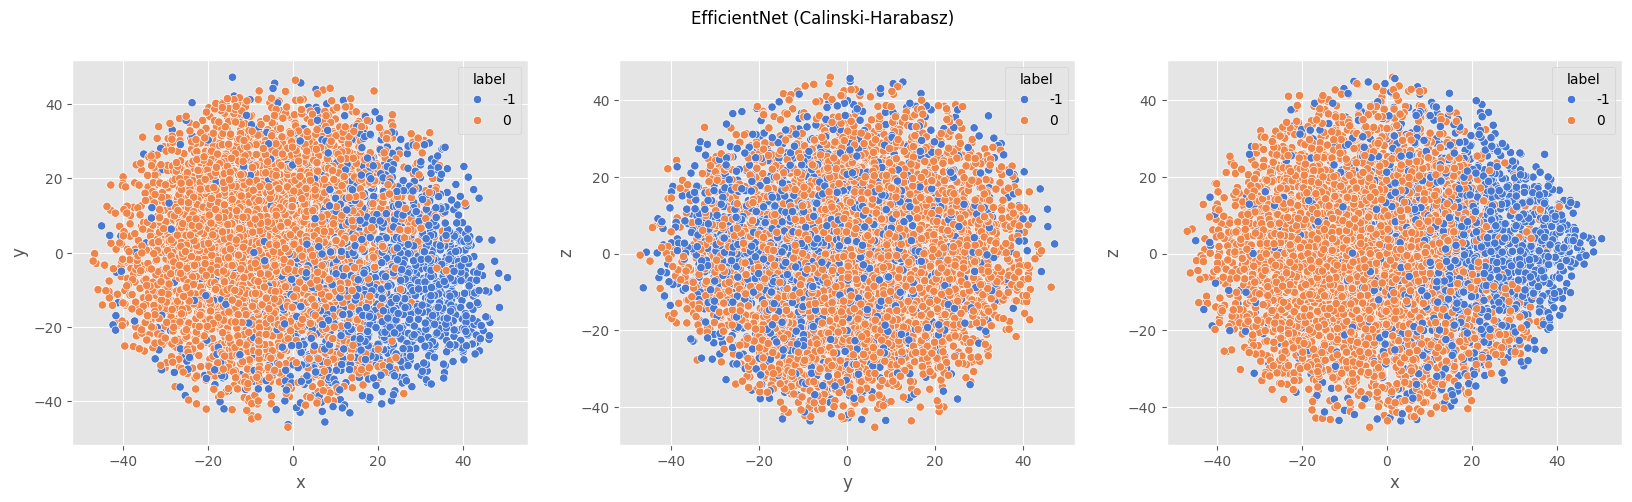

In [17]:
opt_dbscan(X_effnet, effnet_name) 

In [ ]:
outliers_visualiser(X_osnet, osnet_name)

In [ ]:
outliers_visualiser(X_vdc_color, vdc_color_name) 

In [ ]:
outliers_visualiser(X_vdc_type, vdc_type_name) 

## 3.1 Метод MiniBatchKMeans

Поскольку исходных данных много, могут возникнуть проблемы с оперативной памятью и скоростью работы, например при использовании классического алгоритма `K-means`, можно воспользоваться реализацией `MiniBatchKMeans`. 

In [ ]:
def get_clustering_scores(model, data, c_range, rs=None):
    chs_list = []
    dbs_list = []
    
    for c in c_range:
        
        if rs is not None:
            model_ = model(c, random_state=RS)    
        else: 
            model_ = model(c)
        
        labels = model_.fit_predict(data)
        
        chs_list.append(calinski_harabasz_score(data, labels))
        dbs_list.append(davies_bouldin_score(data, labels))
    
    return chs_list, dbs_list


def get_n_clusters(df, aggf):
    c_dict = {}
    
    for col in df.columns:
        if aggf == 'max':
            c_dict[col] = (df[col]
                           .sort_values(ascending=False)
                           .index[0])
        if aggf == 'min':
            c_dict[col] = (df[col]
                           .sort_values(ascending=True)
                           .index[0])
        
    return c_dict

In [ ]:
datasets = {'efficientnet': X_effnet, 
            'osnet': X_osnet, 
            'vdc_color_reg': X_vdc_color, 
            'vdc_type_cl': X_vdc_type}

clusters = list(range(2, 11))


def show_clusters_and_scores(model,
                             datasets=datasets, 
                             clusters=clusters, 
                             rs=None, 
                             sample_data=False):
    
    chs_df = pd.DataFrame(index=clusters)
    chs_name = 'Calinski-Harabasz'
    
    dbs_df = pd.DataFrame(index=clusters) 
    dbs_name = 'Davies-Bouldin'
    
    for name, data in datasets.items():
        if sample_data:
            data = get_sample(data)
        
        if rs is not None:
            chs_df[name] = get_clustering_scores(model, data, clusters, rs)[0]
            dbs_df[name] = get_clustering_scores(model, data, clusters, rs)[1]
        else: 
            chs_df[name] = get_clustering_scores(model, data, clusters)[0]
            dbs_df[name] = get_clustering_scores(model, data, clusters)[1]
    
    metsics = pd.DataFrame(data=[get_n_clusters(chs_df, 'max'), 
                                 get_n_clusters(dbs_df, 'min')], 
                           index=[chs_name, dbs_name])
    
    return metsics


show_clusters_and_scores(MiniBatchKMeans, rs=RS)

In [ ]:
additional_message = ' labels and their counts'




def train_minibatchkmeans(X, n):
    mbkm = MiniBatchKMeans(n_clusters=n, random_state=RS)
    y = mbkm.fit_predict(X)
    
    return y


def n_visualiser(X, n_clusters, train_func, title, n_components=3):
    y = train_func(X, n_clusters)
    print_series(title, y)
    
    clusters_visualiser(X, y, title, n_components)

### Интерпретация кластеров

In [ ]:
clusters_visualiser(X_effnet, y_effnet, effnet_name) 

*Разница между кластерами очень слабая, так как на графике точки очень плотно расположены друг к другу и образуют четкий эллипс в его центре.*

In [ ]:
clusters_visualiser(X_osnet, y_osnet, osnet_name) 

0. прочие
1. белые сзади
2. черные спереди
3. белые спереди
4. черные сзади
5. серебристые спереди
6. прочие (на фото есть желтый цвет)
7. синие
8. красные 
9. зеленые

In [ ]:
clusters_visualiser(X_vdc_color, y_vdc_color, vdc_color_name)

1. серебристые
2. белые 
3. черные 
4. цветные

In [ ]:
clusters_visualiser(X_vdc_type, y_vdc_type, vdc_type_name) 

1. спортивные?
2. грузовые и внедорожники
3. легковые

### Метод Аггломеративной кластеризации

In [ ]:
show_clusters_and_scores(AgglomerativeClustering, sample_data=True) 

In [ ]:
def train_agglomerative_clustering(data, n_clusters, cut_size=5000):
    i_from = list(range(0, 
                        data.shape[0], 
                        cut_size))
    i_to = list(range(cut_size, 
                      data.shape[0], 
                      cut_size)) + [data.shape[0]]

    y = []
    
    for i, j in zip(i_from, i_to):
        X = data[i:j]
        
        model = AgglomerativeClustering(n_clusters=n_clusters)
        y_ = model.fit_predict(X).tolist()
        
        [y.append(label) for label in y_]
    
    return np.array(y) 

In [ ]:
y_effnet = train_agglomerative_clustering(X_effnet, 2)
print_series(effnet_name, y_effnet)

clusters_visualiser(X_effnet, y_effnet, effnet_name) 

In [ ]:
y_osnet = train_agglomerative_clustering(X_osnet, 9)
print_series(osnet_name, y_osnet)

clusters_visualiser(X_osnet, y_osnet, osnet_name) 

In [ ]:
y_vdc_color = train_agglomerative_clustering(X_vdc_color, 3) 
print_series(vdc_color_name, y_vdc_color)

clusters_visualiser(X_vdc_color, y_vdc_color, vdc_color_name)

In [ ]:
y_vdc_type = train_agglomerative_clustering(X_vdc_type, 3)
print_series(vdc_type_name, y_vdc_type) 

clusters_visualiser(X_vdc_type, y_vdc_type, vdc_type_name) 

*Аггломеративная кластеризация не показала достаточной эффективности*

## Метод Гауссовой смеси

In [ ]:
show_clusters_and_scores(GaussianMixture, rs=RS, sample_data=True) 

In [ ]:
def train_gaussianmixture(X, n):
    model = GaussianMixture(n_components=n, random_state=RS)
    y = model.fit_predict(X)
    
    return y 

In [ ]:
y_effnet = train_gaussianmixture(X_effnet, 2)
print_series(effnet_name, y_effnet)

clusters_visualiser(X_effnet, y_effnet, effnet_name) 

In [ ]:
y_osnet = train_gaussianmixture(X_osnet, 7)
print_series(osnet_name, y_osnet)

clusters_visualiser(X_osnet, y_osnet, osnet_name)

In [ ]:
y_vdc_color = train_gaussianmixture(X_vdc_color, 2)
print_series(vdc_color_name, y_vdc_color)

clusters_visualiser(X_vdc_color, y_vdc_color, vdc_color_name)

In [ ]:
y_vdc_type = train_gaussianmixture(X_vdc_type, 5)
print_series(vdc_type_name, y_vdc_type) 

clusters_visualiser(X_vdc_type, y_vdc_type, vdc_type_name)